In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
os.chdir("../src")

In [3]:
from models import IBModel, DecayModel
from subjects_data import read_all, preprocess_data
from config import halflife_vals, subjects_order, betas, regularization_vals
from utils import BETA_STR

In [4]:
PATH = os.path.join(os.path.expanduser("~"), "proj_university\seminar-bci\subject_data")

In [5]:
data = read_all(PATH)
data = preprocess_data(data)

  0%|          | 0/17 [00:00<?, ?it/s]

Exception in HLA:
All arrays must be of the same length


# IB N and $\beta$ in subjects (As given by previous paper results)

In [6]:
print(f"Num of subjects: {data['name'].nunique()}")
print(f"Num of different N: {data['N'].nunique()}")
print(f"Num of different betas: {data['beta_ind'].nunique()}")
data.groupby('name')[['N', 'beta']].first().T

Num of subjects: 16
Num of different N: 12
Num of different betas: 6


name,AT,CK,ES,EW,GG,IG,LV,MH,MN,MZ,RS,SG,SM,SN,YF,ZD
N,42.0,10.000000,9.000000,41.000000,20.000000,41.000000,12.0,19.000000,40.000000,15.0,42.000000,27.000000,15.000000,42.0,18.000000,16.0
beta,100.0,2.636651,48.329302,14.384499,2.636651,61.584821,100.0,2.636651,2.636651,100.0,2.636651,4.281332,2.636651,100.0,48.329302,100.0


# Fitting Models

In [7]:
num_bins = 30
subject_models = dict()

for name in tqdm(data['name'].unique()):
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    N = data.loc[data['name']==name, 'N'].unique().item()
    beta = data.loc[data['name']==name, 'beta'].unique().item()
    
    if auc_normal.isnull().any():
        auc_normal = auc_normal.interpolate(method="linear")
    
    best_decay_model = None
    best_decay_model_prev = None
    best_r2 = -1
    best_r2_prev = -1
    

    for tau in halflife_vals:
        decay_model = DecayModel(tau)
        decay_model.fit(response=auc_normal, sequence=sequence)
        w = decay_model.empiric_weights(sequence, num_bins)
        surprise = decay_model.surprise_predictor(sequence)
        r2 = decay_model.r2(auc_normal, surprise)
        w_r2 = decay_model.r2(auc_normal, surprise, weights=w)
        
        if w_r2 > best_r2:
            best_decay_model = decay_model
            best_r2 = w_r2
    
    ib_model = IBModel(N, beta)
    ib_model.fit()
    surprise = ib_model.surprise_predictor(sequence)
    w = ib_model.inverse_probs(sequence)
    w_ib_r2 = ib_model.r2(auc_normal, surprise, weights=w)
    
    subject_models[name] = {
        "decay": best_decay_model, 
        "IB": ib_model, 
        "scores": {"IB": w_ib_r2, "decay": best_r2}
    }
    
    print(f"{name}\n" +
          f"weighted\t best_tau: {best_decay_model.tau}\t best_r2: {best_r2:.3f}\t " +
          f"IB (N, {BETA_STR}): ({N},{beta:.3f}) r2: {w_ib_r2:.3f}\n")

  0%|          | 0/16 [00:00<?, ?it/s]

AT
weighted	 best_tau: 1	 best_r2: 0.242	 IB (N, β): (42,100.000) r2: 0.284

CK
weighted	 best_tau: 49	 best_r2: 0.452	 IB (N, β): (10,2.637) r2: 0.460

ES
weighted	 best_tau: 42	 best_r2: 0.084	 IB (N, β): (9,48.329) r2: 0.039

EW
weighted	 best_tau: 32	 best_r2: 0.357	 IB (N, β): (41,14.384) r2: 0.371

GG
weighted	 best_tau: 35	 best_r2: 0.293	 IB (N, β): (20,2.637) r2: 0.458

IG
weighted	 best_tau: 1	 best_r2: 0.235	 IB (N, β): (41,61.585) r2: 0.129

LV
weighted	 best_tau: 27	 best_r2: 0.249	 IB (N, β): (12,100.000) r2: 0.046

MH
weighted	 best_tau: 1	 best_r2: 0.149	 IB (N, β): (19,2.637) r2: 0.215

MN
weighted	 best_tau: 18	 best_r2: 0.256	 IB (N, β): (40,2.637) r2: 0.342

MZ
weighted	 best_tau: 1	 best_r2: 0.288	 IB (N, β): (15,100.000) r2: 0.379

RS
weighted	 best_tau: 40	 best_r2: 0.095	 IB (N, β): (42,2.637) r2: 0.068

SG
weighted	 best_tau: 2	 best_r2: 0.271	 IB (N, β): (27,4.281) r2: 0.307

SM
weighted	 best_tau: 1	 best_r2: 0.418	 IB (N, β): (15,2.637) r2: 0.652

SN
weighte

# Plot Surprise vs AUC

In [72]:
def bin_surprise_to_mean_auc(surprise, auc, num_bins):
    """
    TODO calculate error bars
    """
    counts, bins = np.histogram(surprise, bins=num_bins)
    ranks = np.digitize(surprise, bins=bins, right=True)
    df_mean_auc = pd.DataFrame({"surprise":surprise, "ranks":ranks, "auc":auc}).groupby("ranks").mean()
    ranks = df_mean_auc.index.values
    middle_surprise_bins = df_mean_auc['surprise'].values
    mean_auc = df_mean_auc['auc'].values
    return middle_surprise_bins, ranks, mean_auc

def plot_surprise_vs_auc(name):
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    N = data.loc[data['name']==name, 'N'].unique().item()
    beta = data.loc[data['name']==name, 'beta'].unique().item()
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"{name}", fontsize=20)
    fig.subplots_adjust(top=0.85)
    for ax, model_name in zip(axs, ["decay", "IB"]):
        model = subject_models[name][model_name]
        surprise = model.surprise_predictor(sequence)
        score = subject_models[name]['scores'][model_name]
        title = f"tau={model.tau}" if model_name=="decay" else f"N={N}, {BETA_STR}={beta:.2f}"
        title += f"\nR2={score:.3f}"
        
        df_to_plot = pd.concat([auc_normal, pd.Series(surprise,name="surprise")], axis=1)
        df_to_plot.plot(
            kind="scatter", x="surprise", y="auc_normal", title=title, ax=ax, figsize=(15,5))
        surprise, auc = [model.skip_first_trials(arr) for arr in [surprise, auc_normal]]
        bin_means, _, mean_auc = bin_surprise_to_mean_auc(surprise, auc, num_bins=10)
        ax.plot(bin_means, mean_auc, "-o", c='tab:orange')
        ax.set_ylim(auc_normal.min(), auc_normal.max())

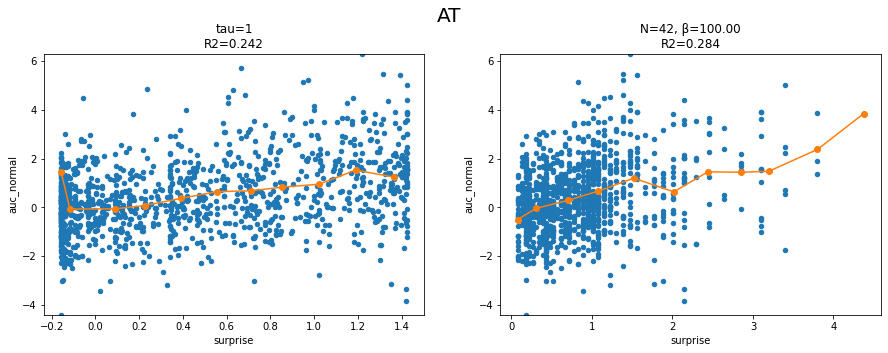

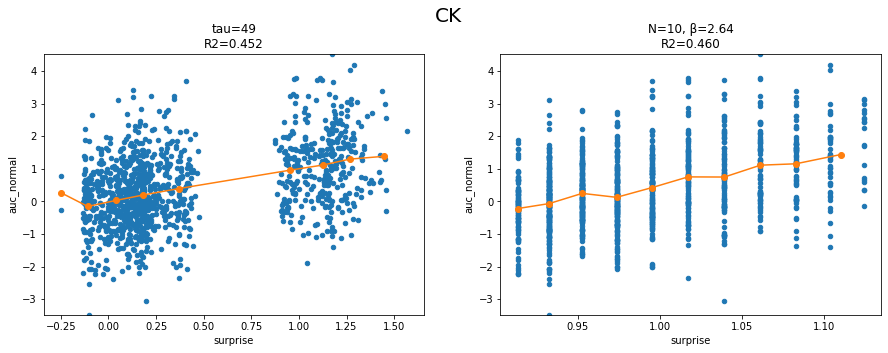

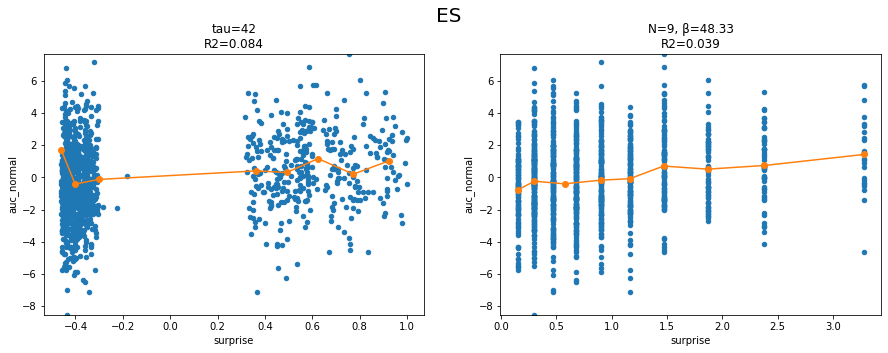

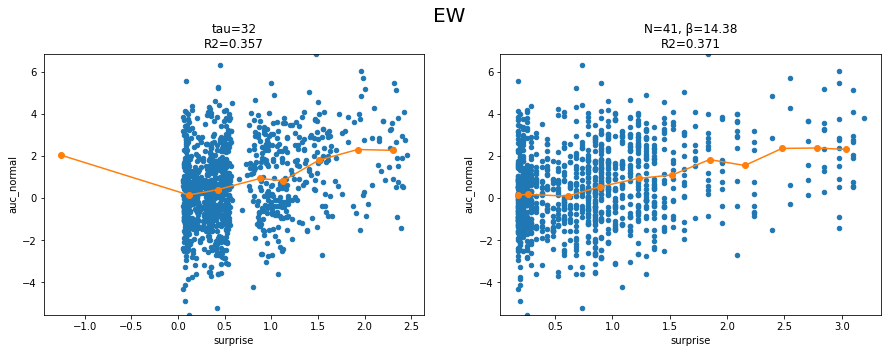

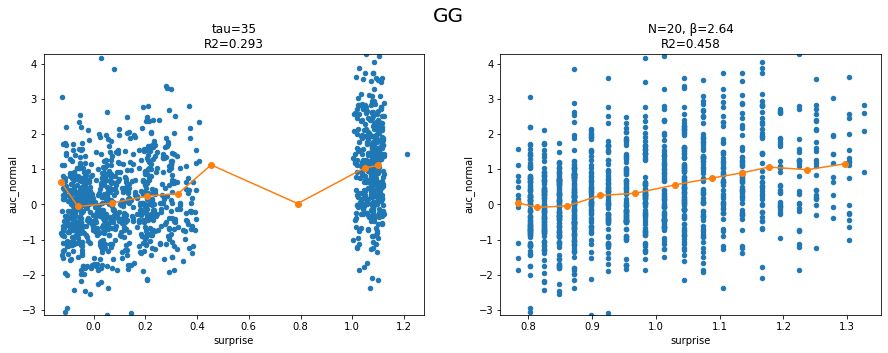

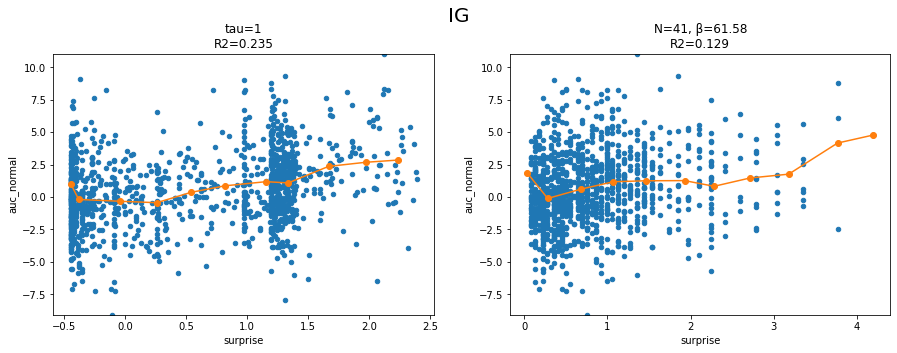

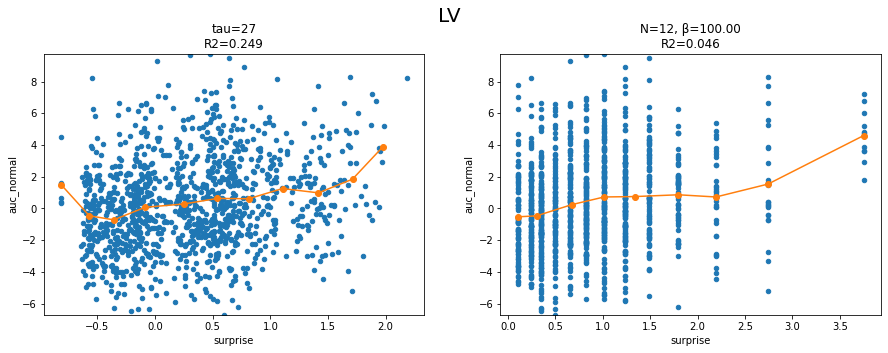

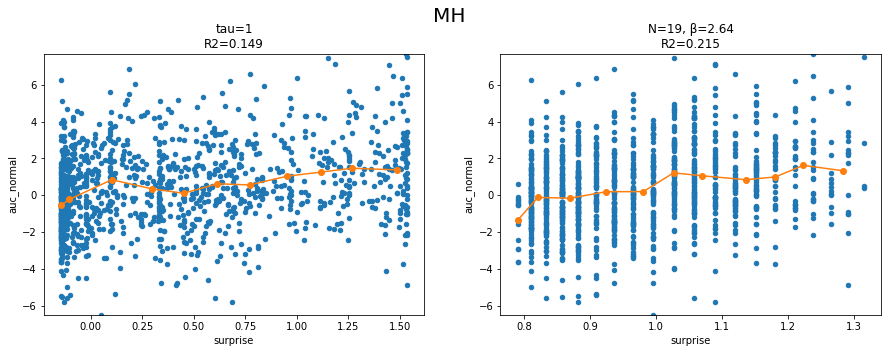

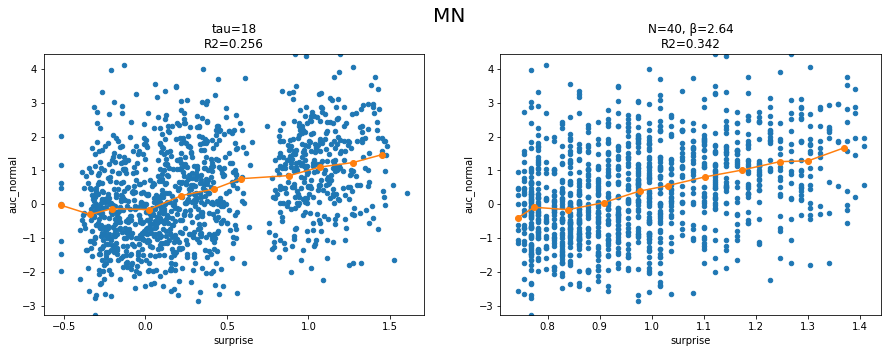

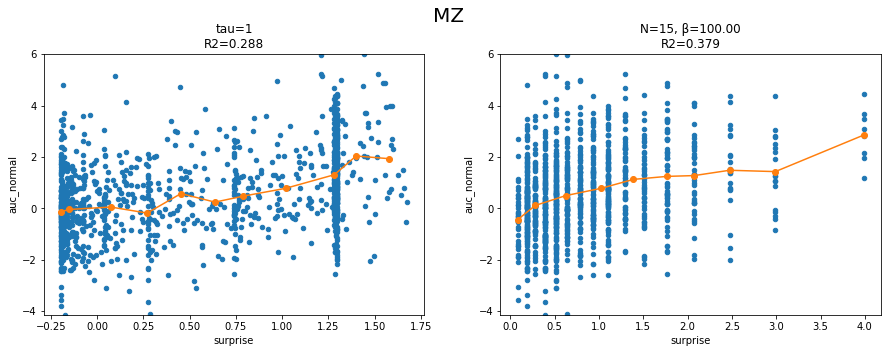

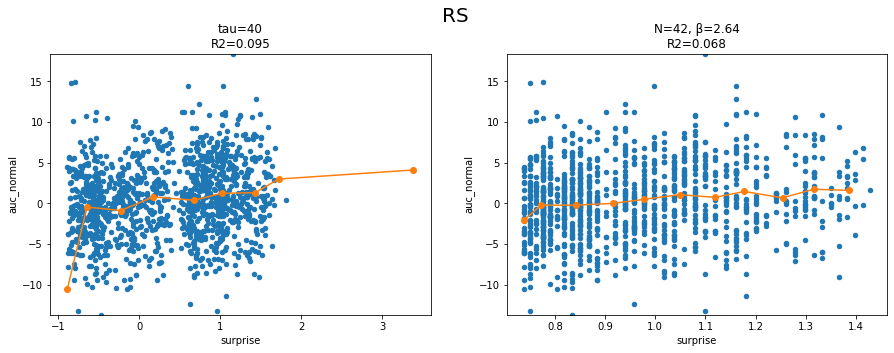

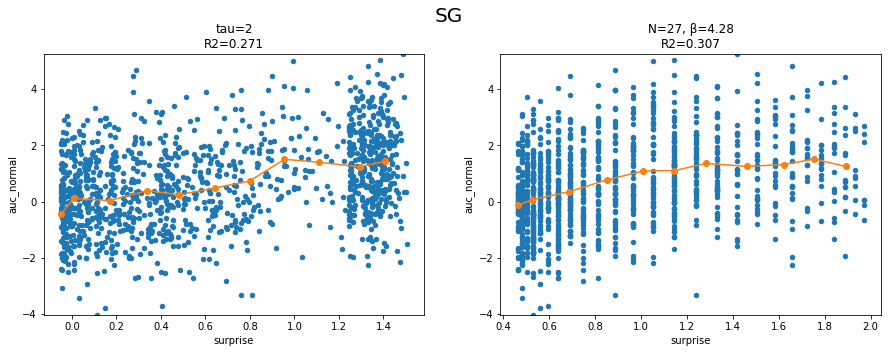

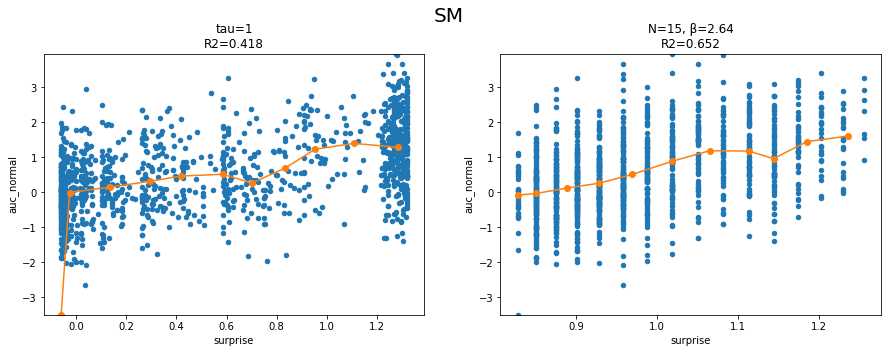

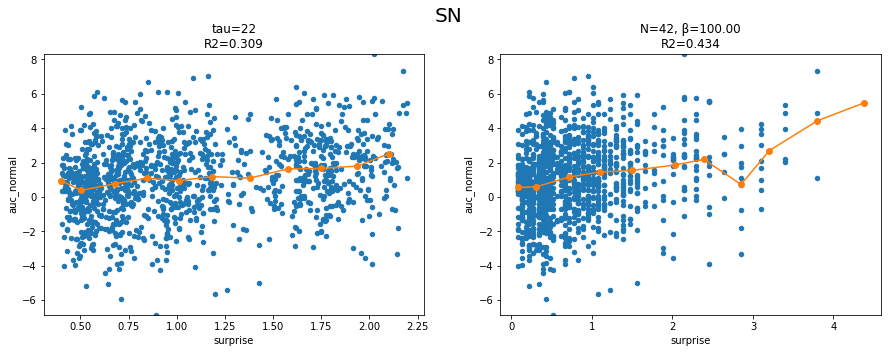

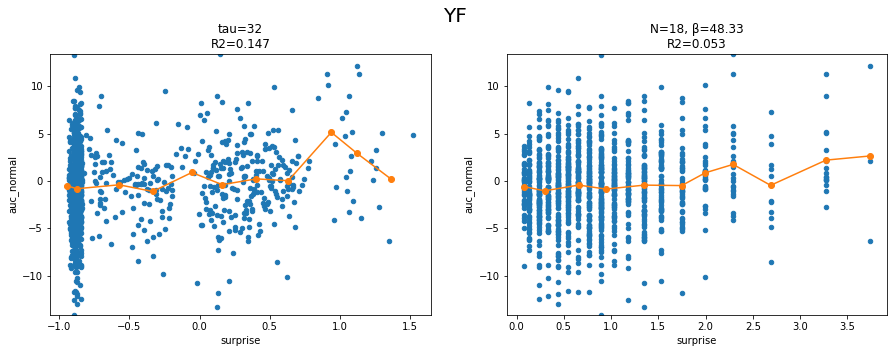

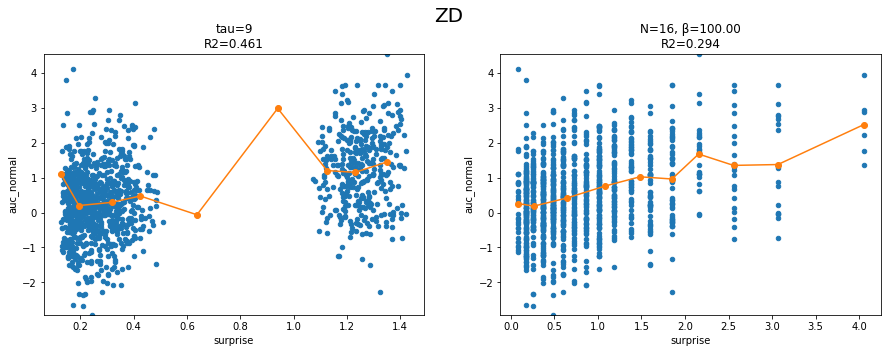

In [73]:
for name in data["name"].unique():
    plot_surprise_vs_auc(name)

# Global Surprise vs AUC

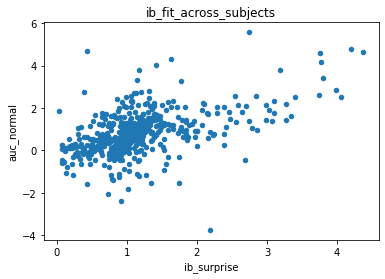

In [22]:
data_gather = data[["name","auc_normal"]].copy()
data_gather['ib_surprise'] = np.nan
for name in data["name"].unique():
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    N = data.loc[data['name']==name, 'N'].unique().item()
    beta = data.loc[data['name']==name, 'beta'].unique().item()


    model = subject_models[name]['IB']
    surprise = model.surprise_predictor(sequence)
    data_gather.loc[data_gather['name']==name, 'ib_surprise'] = surprise
df_to_plot = data_gather.groupby(['ib_surprise'], as_index=False)['auc_normal'].mean()

In [23]:
ib_global_unique_surprise_vals = len(df_to_plot)

In [24]:
data_gather['decay_surprise'] = np.nan
for name in data["name"].unique():
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]

    model = subject_models[name]['decay']
    surprise = model.surprise_predictor(sequence)
    data_gather.loc[data_gather['name']==name, 'decay_surprise'] = surprise
data_gather = data_gather.dropna()    
middle_bins, _, mean_auc = bin_surprise_to_mean_auc(data_gather['decay_surprise'], 
                                                    data_gather['auc_normal'], num_bins=ib_global_unique_surprise_vals)
    


<ipython-input-41-81cef403bf2d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


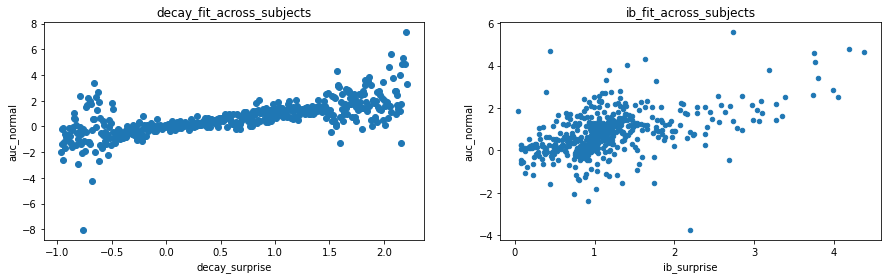

In [41]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].scatter(middle_bins, mean_auc)
axs[0].set_title("decay_fit_across_subjects")
axs[0].set_xlabel("decay_surprise")
axs[0].set_ylabel("auc_normal")
df_to_plot.plot(kind='scatter', x='ib_surprise', y='auc_normal', title="ib_fit_across_subjects", ax=axs[1])
fig.show()

In [30]:
import seaborn as sns

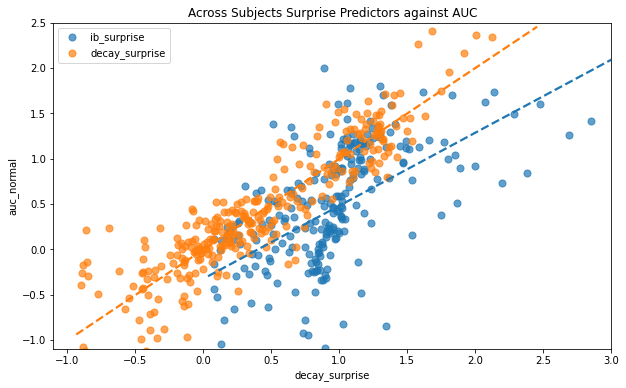

In [61]:
fig, ax = plt.subplots(1, figsize=(10,6))
for xs in ['ib_surprise', 'decay_surprise']:
    sns.regplot(x=xs, y='auc_normal', 
                data=data_gather, ax=ax, x_bins=300,
                label=xs, ci=None, line_kws={'linestyle':'--'}, 
                scatter_kws={'alpha':0.7})
#     sns.regplot(x="decay_surprise", y='auc_normal', data=data_gather, 
#                 x_bins=30, ax=ax, label="Decay", ci=None)
ax.legend()
ax.set_xlim(-1.1, 3)
ax.set_ylim(-1.1, 2.5)
ax.set_title("Across Subjects Surprise Predictors against AUC")
plt.show()


## Regression Metrics

In [28]:
reg_ib = OLS.from_formula('auc_normal ~ ib_surprise', data=data_gather).fit()

In [29]:
reg_decay = OLS.from_formula('auc_normal ~ decay_surprise', data=data_gather).fit()

In [31]:
reg_ib.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             auc_normal   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     620.2
Date:                Thu, 25 Aug 2022   Prob (F-statistic):          1.04e-134
Time:                        00:04:54   Log-Likelihood:                -42151.
No. Observations:               18787   AIC:                         8.431e+04
Df Residuals:                   18785   BIC:                         8.432e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3272      0.034     -9.755      0.000      -0.393      -0.261
ib_surprise     0.8066      0.032     24.903      0.000       0.743       0.870
==============================================================================
Omnibus:                     1714.912   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11717.613
Skew:                          -0.119   Prob(JB):                         0.00
Kurtosis:                       6.862   Cond. No.                         3.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
reg_decay.f_pvalue

0.0

In [32]:
reg_decay.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             auc_normal   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1553.
Date:                Thu, 25 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:05:00   Log-Likelihood:                -41710.
No. Observations:               18787   AIC:                         8.342e+04
Df Residuals:                   18785   BIC:                         8.344e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0051      0.019     -0.266      0.790      -0.043       0.033
decay_surprise     1.0012      0.025     39.405      0.000       0.951       1.051
==============================================================================
Omnibus:                     1764.990   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12840.643
Skew:                           0.092   Prob(JB):                         0.00
Kurtosis:                       7.046   Cond. No.                         1.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Extracting N by Tau to subjects

In [74]:
def N_by_tau(tau):
    intercept = 1.6171428571428534
    coef = 0.24873949579831944
    N = int((tau - intercept)/coef)
    if N < 1:
        N = 1
    return N

In [75]:
df = pd.DataFrame({
    "N(IB)": [subject_models[name]['IB'].N for name in data['name'].unique()],
    "tau(decay)": [subject_models[name]['decay'].tau for name in data['name'].unique()],
}, index = data['name'].unique())
df['N(tau~N_formula)'] = df['tau(decay)'].apply(N_by_tau)
df.T

,AT,CK,ES,EW,GG,IG,LV,MH,MN,MZ,RS,SG,SM,SN,YF,ZD
N(IB),42,10,9,41,20,41,12,19,40,15,42,27,15,42,18,16
tau(decay),1,49,42,32,35,1,27,1,18,1,40,2,1,22,32,9
N(tau~N_formula),1,190,162,122,134,1,102,1,65,1,154,1,1,81,122,29


# Introducing $\lambda$ Regularization Using Ridge Regression

In [43]:
from statsmodels.api import OLS, WLS, add_constant

In [56]:
BLOCK_SIZE = 240
TEST_SIZE = 60
NUM_BLOCKS = 5

def train_test_split(*arrays):
    # change dtype to numpy
    arrays = [series.values if isinstance(series, pd.Series) else series for series in arrays]
    
#     train_idx = np.concatenate([(np.arange(BLOCK_SIZE - TEST_SIZE) + BLOCK_SIZE*i) for i in range(NUM_BLOCKS)])
    train_idx = np.arange(len(arrays[0])-300)
    ret_list = list()
    for arr in arrays:
        ret_list.append(arr[train_idx])
        ret_list.append(np.delete(arr, train_idx))
    return ret_list

In [57]:
train_X, test_X, train_y, test_y = train_test_split(sequence, auc_normal)

In [ ]:
d_new_ib_models = dict()

for name in tqdm(data['name'].unique()):
    d_new_ib_models[name] = dict()
    
    sequence = data.loc[data["name"]==name, "block"].astype(np.int32)
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    tau = subject_models[name]['decay'].tau
    N = N_by_tau(tau)

    for beta_ind in range(len(betas)):
        best_rmse = -1.
        best_model = None
        best_alpha = -1.
        for alpha in regularization_vals:
            ib_model = IBModel(N, betas[beta_ind]).fit()
            surprise = ib_model.surprise_predictor(sequence)
            w = ib_model.inverse_probs(sequence)
            # split
            train_surprise, test_surprise, train_auc, test_auc, train_w, test_w = train_test_split(
                surprise, auc_normal, w)
            
            # truncate first trials if IB
            train_surprise, train_auc, train_w = [ib_model.skip_first_trials(arr) for arr in [train_surprise, train_auc, train_w]]
            
            # fit
            reg = WLS(train_auc, add_constant(train_surprise), weights=train_w).fit_regularized(alpha=alpha)
            
            # score test
            preds = reg.predict(add_constant(test_surprise))
            
            rmse = np.sqrt(np.sum((preds - test_auc)**2)/len(test_auc))
            if rmse > best_rmse:
                best_rmse = rmse
                best_model = ib_model
                best_alpha = alpha
        
        # save reg lambda of best model for each beta
        d_new_ib_models[name][beta_ind] = {"model": best_model, "lambda": best_alpha} 

  0%|          | 0/16 [00:00<?, ?it/s]